In [11]:
#!pip install dataframe-image

In [12]:
%matplotlib inline

#-----------------------------------------------------------
import os
import math
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import cm        # module palettes de couleurs
import pandas as pd
import dataframe_image as dfi
import seaborn as sns
from sklearn.decomposition import PCA
#-----------------------------------------------------------
#np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth = 220)
np.set_printoptions(precision=4)
#np.set_printoptions(precision=3,formatter={'float': '{:9.3f}'.format})
pd.set_option('precision', 5)
pd.set_option("display.max_columns",20)
pd.set_option('display.max_rows', 999)
#pd.set_option('max_colwidth', 6)


## Chargement des données

Regardons d'abord les 2 bases de données que l'on a à disposition :


*   *'global_data'* : base de données composée de 9000 relevés pour lesquels la concentration en 10 types de pigments a été mesurée
*   *'tara_data'* : base de données de 211 relevés pour lesquels les mêmes concentrations sont mesurées, auxquelles s'ajoutent le pourcentage de 7 groupe de phytoplanctons dans l'échantillon.






In [13]:
# 9000 lignes x 10 pigments
# global_data = pd.read_excel('Data_Etude_de_Cas.xlsx',sheet_name='Global HPLC Data')
df_global_data = pd.read_excel('Data_Etude_de_Cas.xlsx',sheet_name='Global HPLC Data',usecols = 'F:O') #global data sans les colonnes dates

# 210 lignes x (10 pigments + 7 % de phytoplanctons)
df_tara_data = pd.read_excel('Data_Etude_de_Cas.xlsx',sheet_name='Tara Data Phyto + HPLC',usecols = 'G:W')


In [14]:
df_global_data.head()

,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
0,0.482,0.055,0.059,NaN,0.085,0.016,0.029,0.017,0.007,0.188
1,1.248,0.000,0.277,NaN,0.248,0.061,0.332,0.064,0.106,0.039
2,1.517,0.000,0.206,NaN,0.234,0.065,0.636,0.056,0.207,0.030
3,3.363,0.000,0.000,NaN,0.137,0.035,2.057,0.085,0.000,0.048
4,1.325,0.000,0.192,NaN,0.288,0.053,0.336,0.152,0.032,0.174


In [15]:
df_tara_data.head()

,Diatoms,Coccolithophores (Haptophytes),Dinoflagellates,Prochlorococcus,Synechococcus,chlorophytes,other_Haptophytes,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00378,0.01410,0.02332,0.68080,0.15722,0.03385,0.03577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.01393,0.01678,0.03135,0.19303,0.43812,0.04704,0.12771,0.42017,0.00126,0.03323,0.0,0.02532,0.00388,0.12139,0.0,0.00154,0.00696


# 1. **Etude unidimensionnelle**

## 1.1. Grande base de données *global_data*

### Caractéristiques unidimensionnelles

In [16]:
df_global_data.describe()

,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
count,9484.00000,3945.00000,8242.00000,2312.00000,9442.00000,9295.00000,9269.00000,8500.00000,8088.00000,8520.00000
mean,1.54416,0.03178,0.05721,0.00295,0.18065,0.04242,0.85459,0.07378,0.06015,0.05247
std,3.68796,0.08862,0.20121,0.01748,0.69556,0.11607,2.98596,0.58111,0.20495,0.14162
min,0.00000,0.00000,0.00000,0.00000,-0.00320,0.00000,-0.00310,0.00000,-0.00290,0.00000
25%,0.15300,0.00000,0.00400,0.00000,0.02477,0.00600,0.01500,0.00000,0.00000,0.00035
50%,0.39189,0.01242,0.01741,0.00000,0.06300,0.01839,0.07946,0.00423,0.00441,0.01853
75%,1.17046,0.04160,0.05470,0.00010,0.13900,0.04500,0.37200,0.02000,0.03590,0.05900
max,92.41320,3.05633,9.12550,0.34100,13.34613,4.61160,100.77410,25.64400,5.45264,2.39130


### Box-plot

In [17]:
pigments = df_global_data.columns
pigments

Index(['Chlorophyll a, total', 'Divinyl chlorophyll a', 'Chlorophyll b',
       'Divinyl chlorophyll b', '19-Hexanoyloxyfucoxanthin',
       '19-Butanoyloxyfucoxanthin', 'Fucoxanthin', 'Peridinin', 'Alloxanthin',
       'Zeaxanthin'],
      dtype='object')

In [18]:
#df_global_data.iloc[].head()

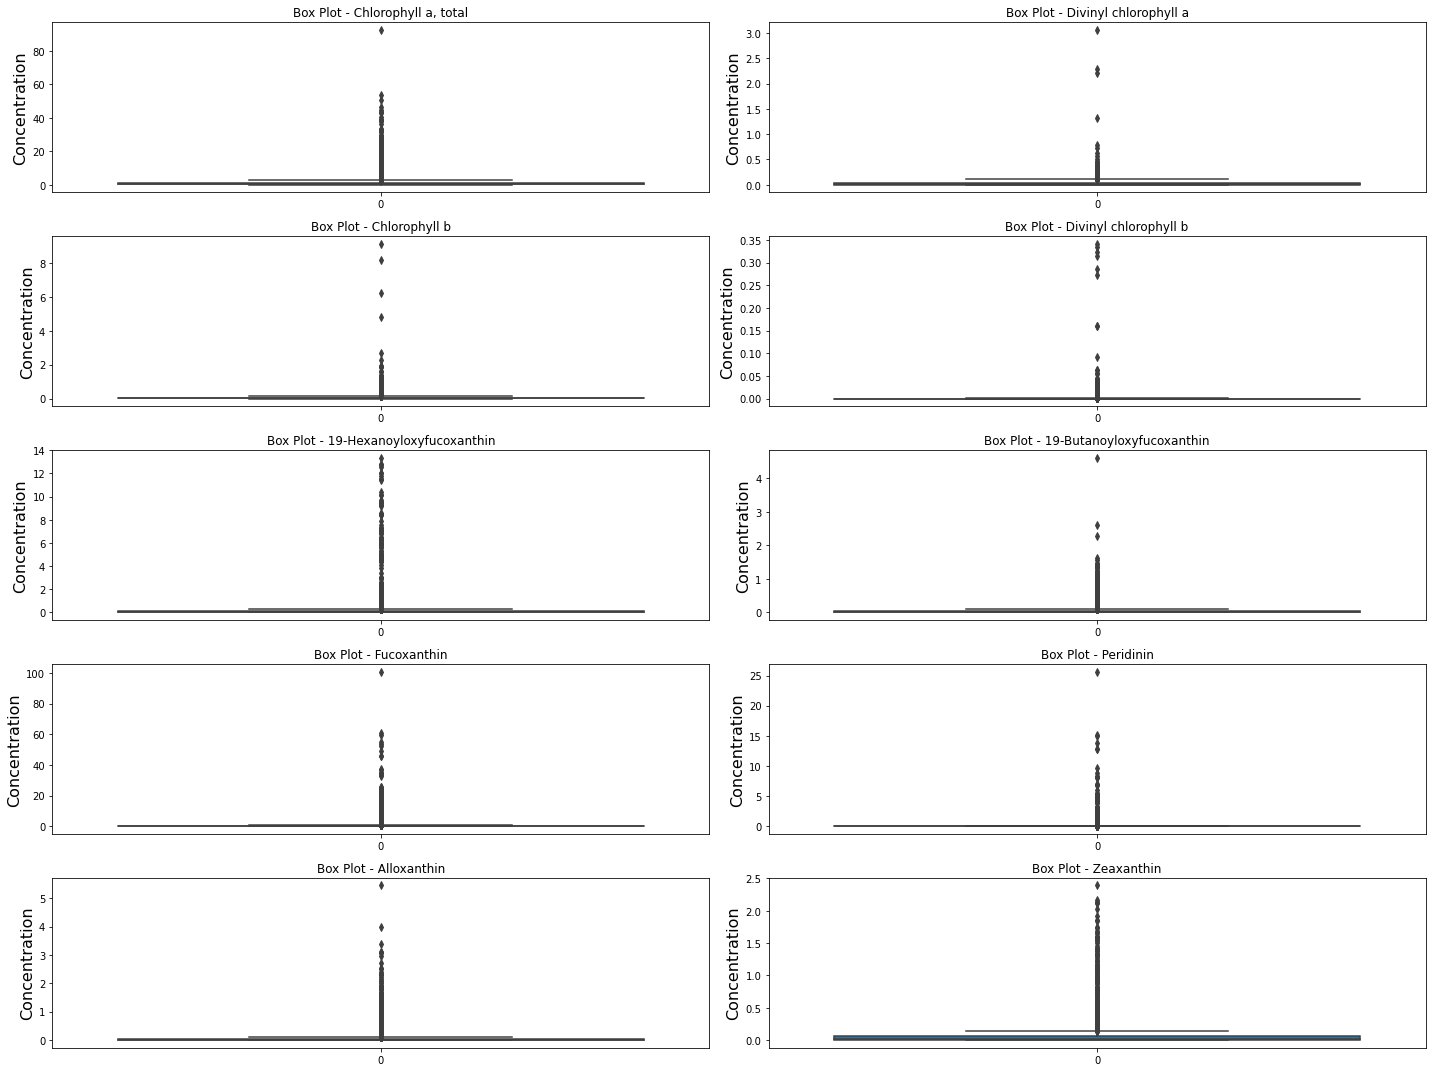

In [19]:
nb_variables = 10
figure = plt.figure(figsize=(20, 15))
nbPlt = nb_variables*(nb_variables-1)/2
nb_c = 2
# nb_l = int(np.ceil(nbPlt/nb_c))
nb_l = 5
cpt=0
for i in range(nb_variables):
        cpt+=1
        ax=plt.subplot(nb_l,nb_c,cpt)
        sns.boxplot(data=df_global_data.iloc[:,i])
        #plt.xlabel(f'Concentration',fontsize=16)
        plt.ylabel('Concentration',fontsize=16)
        plt.title(f"Box Plot - {pigments[i]}")
        plt.tight_layout()
        #plt.xscale('log')
 

### Histogrammes des variables

On s'intéresse d'abord à la répartition des concentrations de chaque pigment pour la grosse base de données *'global_data'*.

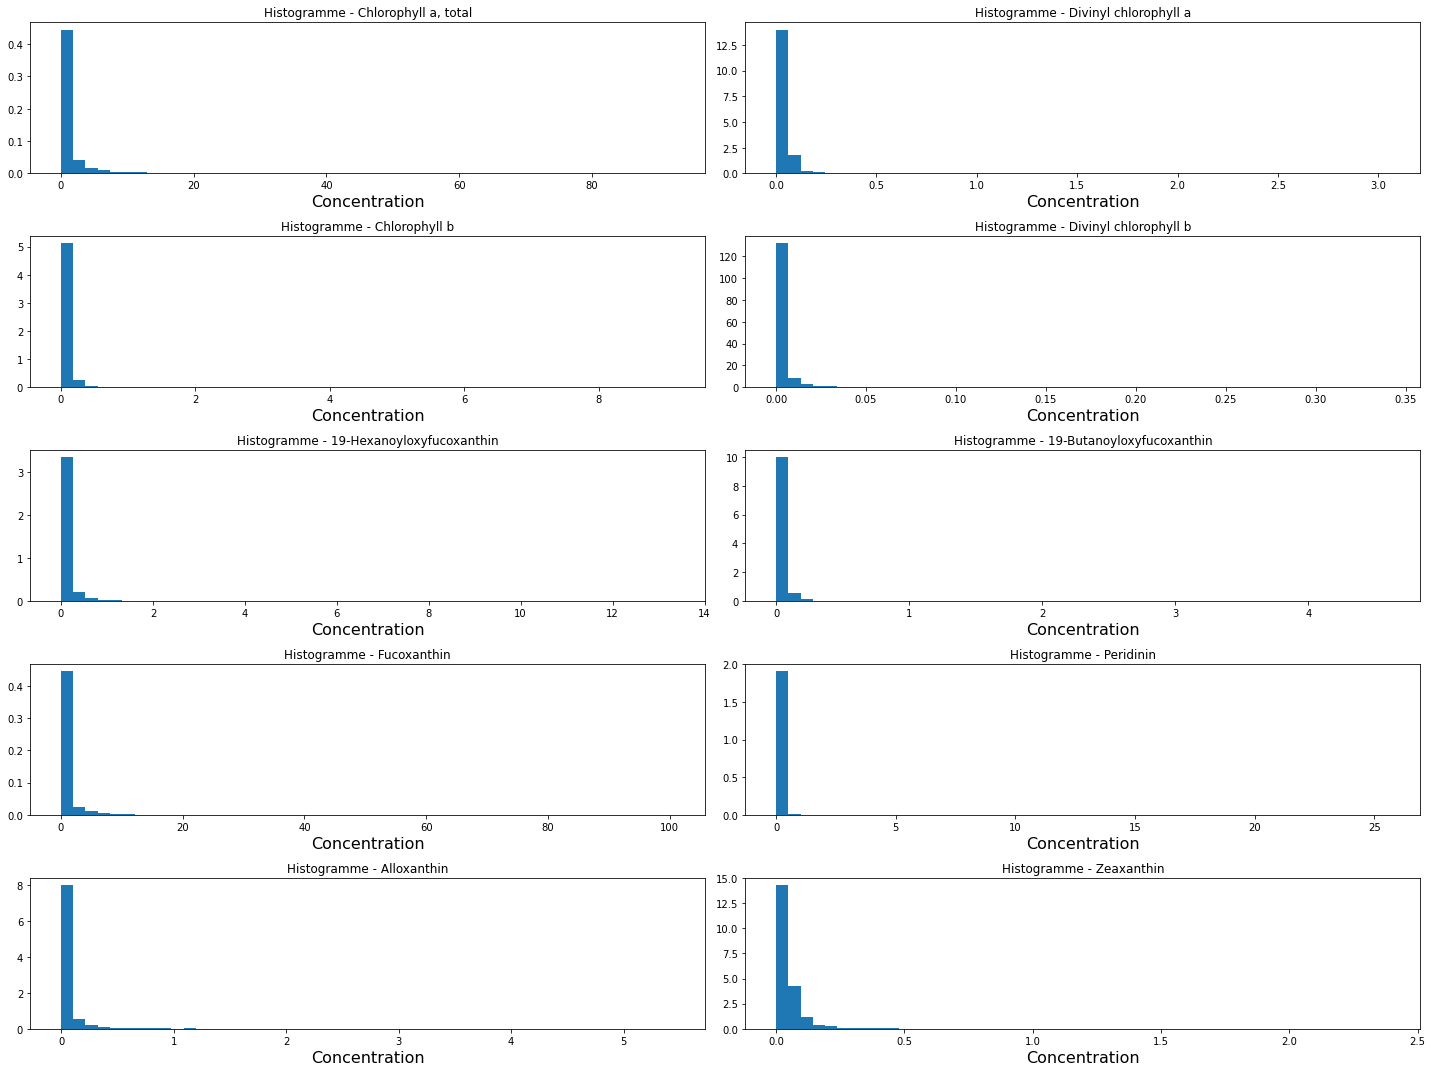

In [20]:

nb_variables = 10
figure = plt.figure(figsize=(20, 15))
nbPlt = nb_variables*(nb_variables-1)/2
nb_c = 2
# nb_l = int(np.ceil(nbPlt/nb_c))
nb_l = 5
cpt=0
for i in range(nb_variables):
        cpt+=1
        ax=plt.subplot(nb_l,nb_c,cpt)
        ax.hist(df_global_data[pigments[i]].values, density=True, bins=50)
        plt.xlabel(f'Concentration',fontsize=16)
        #plt.ylabel(f'{}',fontsize=16)
        plt.title(f"Histogramme - {pigments[i]}")
        plt.tight_layout()
        #plt.xscale('log')

## 1.2. Base de données *tara_data*

In [21]:
columns_taradata = df_tara_data.columns

# 2. Analyse des valeurs manquantes

Dans cette partie, on va s'intéresser aux données manquantes des tableaux. Celles-ci apparaissent sous la forme *'NaN'*.

## 2.1. Base de données *global_data*

### Décompte sur les variables

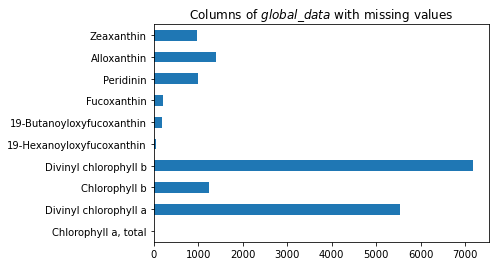

In [22]:
df_global_data.isna().sum().plot.barh()
plt.title('Columns of $global\_data$ with missing values')
plt.show()

On remarque aussi que certaines variables ont une proportion de valeurs NaN considérables. Calculons ce pourcentage.

In [23]:
pctg_nan_global = np.reshape(np.array(df_global_data.isna().sum()/np.shape(df_global_data)[0]*100),(1,10))
df_pctgNaN_global = pd.DataFrame(np.around(pctg_nan_global,2),columns = pigments, index = ['% de NaN'])
display(df_pctgNaN_global)

,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
% de NaN,0.0,58.4,13.1,75.62,0.44,1.99,2.27,10.38,14.72,10.16


In [25]:
dfi.export(df_pctgNaN_global, 'Tableau pctge NaN global.png')

### Valeurs négatives

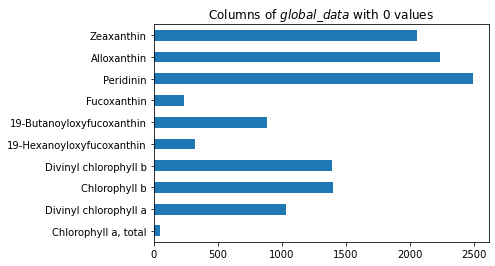

In [26]:
(df_global_data == 0).sum(axis=0).plot.barh()
plt.title('Columns of $global\_data$ with 0 values')
plt.show()

In [27]:
((df_global_data < 0)).sum(axis=0)

Chlorophyll a, total         0
Divinyl chlorophyll a        0
Chlorophyll b                0
Divinyl chlorophyll b        0
19-Hexanoyloxyfucoxanthin    1
19-Butanoyloxyfucoxanthin    0
Fucoxanthin                  2
Peridinin                    0
Alloxanthin                  3
Zeaxanthin                   0
dtype: int64

Le résultat ci-dessus nous montre que certaines valeurs de concentrations sont négatives. Ceci est bien évidemment impossible et résulte d'une erreur de mesure ou de retranscription.

On peut soit dire que c'est une erreur de frappe et prendre la valeur absolue, soit refaire une imputation en ciblant les valeurs négatives, soit attribuer 0 aux valeurs négatives.

N'ayant pas d'informations précises à ce sujet, on choisira la dernière option.

In [28]:
df_global_data[df_global_data < 0] = 0

### NaN par individu

On aimerait savoir si certains individus possèdent plus de la moitié de leurs valeurs nulles; auquel cas, on pourrait les considérer comme peu significatifs et donc décider de ne pas les considérer pour ne pas fausser l'interprétation.

In [29]:
seuil_individu = 0.75

In [30]:
nbNaN_indiv_global = df_global_data.isna().sum(axis=1)

In [31]:
index_indiv_global_seuilNaN = np.where(nbNaN_indiv_global/np.shape(df_global_data)[1] > seuil_individu)

In [32]:
nb_indiv_global_seuilNaN = np.shape(index_indiv_global_seuilNaN)[1]
print(f'On a donc {nb_indiv_global_seuilNaN} individu qui présente {seuil_individu*100}% ou plus de valeurs manquantes.')

On a donc 41 individu qui présente 75.0% ou plus de valeurs manquantes.


## 2.2. Base de données *tara_data*

### Décompte sur les variables

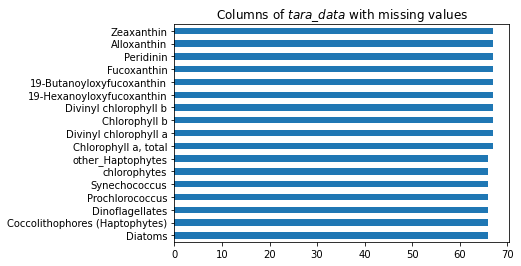

In [33]:
is_column_with_NaN = df_tara_data.isna().sum()
is_column_with_NaN[is_column_with_NaN != 0].plot.barh()
plt.title('Columns of $tara\_data$ with missing values')
plt.show()

In [34]:
pctg_nan_tara = np.reshape(np.array(df_tara_data.isna().sum()/np.shape(df_tara_data)[0]*100),(1,17))
df_pctgNaN_tara = pd.DataFrame(np.around(pctg_nan_tara,2),columns = columns_taradata, index = ['% de NaN'])
display(df_pctgNaN_tara)

,Diatoms,Coccolithophores (Haptophytes),Dinoflagellates,Prochlorococcus,Synechococcus,chlorophytes,other_Haptophytes,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
% de NaN,31.28,31.28,31.28,31.28,31.28,31.28,31.28,31.75,31.75,31.75,31.75,31.75,31.75,31.75,31.75,31.75,31.75


In [35]:
dfi.export(df_pctgNaN_tara, 'Tableau pctge NaN tara.png')

### NaN par individus

In [36]:
nbNaN_indiv_tara = df_tara_data.isna().sum(axis=1)
index_indiv_tara_seuilNaN = np.where(nbNaN_indiv_tara/np.shape(df_tara_data)[1] > seuil_individu)

In [37]:
nb_indiv_tara_seuilNaN = np.shape(index_indiv_tara_seuilNaN)[1]
print(f'On a donc {nb_indiv_tara_seuilNaN} individu qui présente {seuil_individu*100}% ou plus de valeurs manquantes.')

On a donc 28 individu qui présente 75.0% ou plus de valeurs manquantes.


### Valeurs négatives

Pas de valeurs négatives dans la base de données tara.

# 3. **Etude bi-dimensionnelle**

## 3.1. Données brutes

### a) Corrélations des variables de *global_data*

In [38]:
df_global_data.corr()

,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
"Chlorophyll a, total",1.00000,-0.06194,0.36365,-0.01328,0.09536,0.12494,0.63218,0.46702,0.31446,0.12861
Divinyl chlorophyll a,-0.06194,1.00000,-0.06417,0.20846,-0.03670,-0.02062,-0.08937,-0.04830,-0.10159,0.27040
Chlorophyll b,0.36365,-0.06417,1.00000,-0.02682,0.03800,0.03127,0.13016,0.30308,0.14270,0.20323
Divinyl chlorophyll b,-0.01328,0.20846,-0.02682,1.00000,0.11675,0.22185,0.00611,-0.01508,-0.00377,0.01133
19-Hexanoyloxyfucoxanthin,0.09536,-0.03670,0.03800,0.11675,1.00000,0.06753,0.04268,-0.00762,0.13072,-0.02032
19-Butanoyloxyfucoxanthin,0.12494,-0.02062,0.03127,0.22185,0.06753,1.00000,0.21145,0.01390,0.00350,-0.03432
Fucoxanthin,0.63218,-0.08937,0.13016,0.00611,0.04268,0.21145,1.00000,0.15628,0.07138,-0.01184
Peridinin,0.46702,-0.04830,0.30308,-0.01508,-0.00762,0.01390,0.15628,1.00000,0.15346,0.13548
Alloxanthin,0.31446,-0.10159,0.14270,-0.00377,0.13072,0.00350,0.07138,0.15346,1.00000,0.09964
Zeaxanthin,0.12861,0.27040,0.20323,0.01133,-0.02032,-0.03432,-0.01184,0.13548,0.09964,1.00000


In [39]:
base_filename = os.getcwd()+'/Images'
base_filename

'C:\\Users\\paulg\\Documents\\Master TRIED\\Cours\\Etude de cas\\Git repository\\Etude_de_cas_TRIED/Images'

In [40]:
# fig = plt.figure(figsize=(16,10))
# base_filename = os.getcwd()+'/Images'
# ax = sns.heatmap(df_global_data.corr(method='pearson'), annot=True, fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
# #
# filename_png = base_filename +"_correlations_data_global.png"
# plt.savefig(filename_png, dpi=300)

La matrice de corrélation, que ce soit en utilisant les coefficients de Pearson ou de Spearman (sur les rangs), ne permet pas de mettre en lumière une corrélation linéaire entre les différentes variables. Ceci est vrai pour toutes les variables à l'exception de la *'Chlorophyll a, total'* qui semble être corrélée au *'Fucoxanthin'*. 

Essayons maintenant de tracer les diagrammes de dispersion afin d'observer une potentielle relation autre que linéaire entre les variables.

In [41]:
# fig = plt.figure(figsize=(16,10))
# g = sns.pairplot(df_global_data, diag_kind="kde", markers="+",
#                   plot_kws=dict(s=50, edgecolor="b", linewidth=1),
#                   diag_kws=dict(shade=True))

On peut avancer que certaines courbes semblent suivre une loi inverse de la forme $y = \frac{1}{x^p}$. Il apparaît donc intéressant de tracer d'étudier la relation entre les logarithmes des variables. On verra ça un peu plus loin.

### b) Corrélations des datas tara

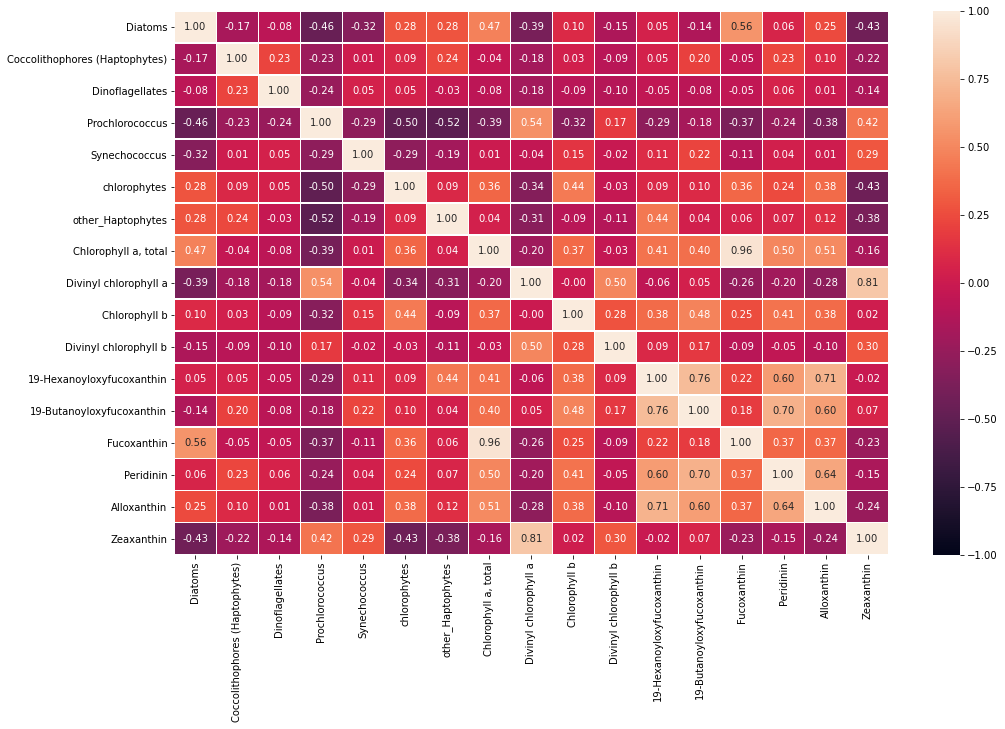

In [88]:
fig = plt.figure(figsize=(16,10))
base_filename = os.getcwd()+'/Images'
ax = sns.heatmap(df_tara_data.corr(method='pearson').iloc[:,:], annot=True, fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
#
filename_png = base_filename +"_correlations_tara.png"
plt.savefig(filename_png, dpi=300)

In [43]:
# fig = plt.figure(figsize=(16,10))
# base_filename = os.getcwd()+'/Images'
# ax = sns.heatmap(df_tara_data.corr(method='pearson').iloc[7:,:], annot=True, fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
# #
# filename_png = base_filename +"_correlations_tara.png"
# plt.savefig(filename_png, dpi=300)

In [44]:
# fig = plt.figure(figsize=(16,10))
# g = sns.pairplot(df_tara_data, diag_kind="kde", markers="+",
#                   plot_kws=dict(s=50, edgecolor="b", linewidth=1),
#                   diag_kws=dict(shade=True))

## 3.2. Données transformées $X' = ln(1+X)$ 

In [45]:
df_ln_global = np.log(df_global_data + 1)
df_ln_global.head()

,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
0,0.39339,0.05354,0.05733,NaN,0.08158,0.01587,0.02859,0.01686,0.00698,0.17227
1,0.81004,0.00000,0.24451,NaN,0.22154,0.05921,0.28668,0.06204,0.10075,0.03826
2,0.92307,0.00000,0.18731,NaN,0.21026,0.06297,0.49225,0.05449,0.18814,0.02956
3,1.47316,0.00000,0.00000,NaN,0.12839,0.03440,1.11743,0.08158,0.00000,0.04688
4,0.84372,0.00000,0.17563,NaN,0.25309,0.05164,0.28968,0.14150,0.03150,0.16042


In [46]:
df_ln_tara = np.log(df_tara_data + 1)
df_ln_tara.head()

,Diatoms,Coccolithophores (Haptophytes),Dinoflagellates,Prochlorococcus,Synechococcus,chlorophytes,other_Haptophytes,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00377,0.01400,0.02305,0.51927,0.14602,0.03329,0.03514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.01384,0.01664,0.03086,0.17649,0.36334,0.04597,0.12019,0.35077,0.00126,0.03269,0.0,0.02501,0.00387,0.11457,0.0,0.00154,0.00694


### a) Corrélations ln_global

In [47]:
# fig = plt.figure(figsize=(16,10))
# base_filename = os.getcwd()+'/Images'
# ax = sns.heatmap(df_ln_global.corr(method='kendall'), annot=True, fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
# 
# filename_png = base_filename +"_correlations_ln_data_global.png"
# plt.savefig(filename_png, dpi=300)

In [48]:
# fig = plt.figure(figsize=(16,10))
# g = sns.pairplot(df_ln_tara, diag_kind="kde", markers="+",
#                   plot_kws=dict(s=50, edgecolor="b", linewidth=1),
#                   diag_kws=dict(shade=True))

### b) Corrélations ln_tara

In [49]:
# fig = plt.figure(figsize=(16,10))
# base_filename = os.getcwd()+'/Images'
# ax = sns.heatmap(df_ln_tara.corr().iloc[:7,:], annot=True, fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
# #
# filename_png = base_filename +"_correlations_tara.png"
# plt.savefig(filename_png, dpi=300)

In [50]:
# fig = plt.figure(figsize=(16,10))
# base_filename = os.getcwd()+'/Images'
# ax = sns.heatmap(df_ln_tara.corr().iloc[7:,:], annot=True, fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
# #
# filename_png = base_filename +"_correlations_tara.png"
# plt.savefig(filename_png, dpi=300)

In [51]:
# fig = plt.figure(figsize=(16,10))
# g = sns.pairplot(df_ln_tara.iloc[:,7:], diag_kind="kde", markers="+",
#                   plot_kws=dict(s=50, edgecolor="b", linewidth=1),
#                   diag_kws=dict(shade=True))

# 4. Imputation des valeurs manquantes

Au vu des histogrammes et tableaux de valeurs manquantes (NaN), on décide de procéder à une imputation des données manquantes. Pour cela, on essaie différentes méthodes.

## 4.0. Normalisation des données 

In [52]:
#Global data
df_global_data_normalized =(df_global_data-df_global_data.mean())/df_global_data.std()
#np.around(df_global_data_normalized.describe())

#Tara data
df_tara_data_normalized =(df_tara_data-df_tara_data.mean())/df_tara_data.std()
#np.around(df_tara_data_normalized.describe())

## 4.1. K-Nearest-Neighbours (KNN)

Cette méthode d'imputation est directement codée sur scikit learn. Elle est appelée *KNNImputer()*.
Les informations sur cette méthode sont disponibles au lien : https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

### a) Imputation

In [53]:
#Importation de l'environnement adéquat
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [54]:
#Définition de l'imputer
imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights= 'uniform')

On ne va considérer que les individus ayant suffisamment de valeurs dans leur ligne. Ceux dont le pourcentage de NaN est supérieur au seuil défini précédemment ne seront pas considérés.

In [55]:
#Suppression des individus insignifiants (i.e. qui ont trop de NaN)
global_data_preparedKNN = df_global_data_normalized.drop(index = index_indiv_global_seuilNaN[0])
tara_data_preparedKNN = df_tara_data_normalized.drop(index = index_indiv_tara_seuilNaN[0])

In [56]:
#Imputation des données
global_data_KNNimputed = imputer.fit_transform(global_data_preparedKNN)
df_global_data_KNNimputed = pd.DataFrame(global_data_KNNimputed,columns=pigments)

tara_data_KNNimputed = imputer.fit_transform(tara_data_preparedKNN)
df_tara_data_KNNimputed = pd.DataFrame(tara_data_KNNimputed,columns=columns_taradata)

### b) Analyse des résultats

#### *Global_data*

In [57]:
#Données initiales
#df_global_data.head()
global_data_preparedKNN.describe()

,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
count,9443.00000,3.94500e+03,8.24200e+03,2.31200e+03,9440.00000,9.29500e+03,9.26900e+03,8.50000e+03,8.08800e+03,8493.00000
mean,0.00152,-6.24538e-15,2.71192e-15,3.27953e-16,-0.00020,2.91591e-15,-1.24628e-15,2.39405e-15,5.32950e-15,0.00002
std,1.00185,1.00000e+00,1.00000e+00,1.00000e+00,1.00000,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00153
min,-0.41870,-3.58637e-01,-2.84353e-01,-1.68810e-01,-0.25972,-3.65483e-01,-2.86203e-01,-1.26958e-01,-2.93481e-01,-0.37051
25%,-0.37688,-3.58637e-01,-2.64473e-01,-1.68810e-01,-0.22413,-3.13788e-01,-2.81179e-01,-1.26958e-01,-2.93481e-01,-0.36828
50%,-0.31187,-2.18518e-01,-1.97804e-01,-1.68810e-01,-0.16915,-2.07063e-01,-2.59592e-01,-1.19680e-01,-2.71980e-01,-0.24100
75%,-0.10027,1.10801e-01,-1.24986e-02,-1.63090e-01,-0.05989,2.22266e-02,-1.61619e-01,-9.25408e-02,-1.18315e-01,0.04575
max,24.63939,3.41307e+01,4.50686e+01,1.93354e+01,18.92774,3.93670e+01,3.34631e+01,4.40023e+01,2.63115e+01,16.51461


In [58]:
#Données imputées
#df_global_data_KNNimputed.head()
df_global_data_KNNimputed.describe()

,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
count,9443.00000,9443.00000,9443.00000,9443.00000,9443.00000,9443.00000,9443.00000,9443.00000,9443.00000,9443.00000
mean,0.00152,-0.11626,-0.00235,-0.00354,-0.00027,-0.00134,-0.00484,-0.00398,0.00170,-0.00386
std,1.00185,0.67653,0.94403,0.76564,0.99985,0.99279,0.99141,0.95251,0.98631,0.95601
min,-0.41870,-0.35864,-0.28435,-0.16881,-0.25972,-0.36548,-0.28620,-0.12696,-0.29348,-0.37051
25%,-0.37688,-0.35751,-0.26292,-0.16881,-0.22414,-0.31379,-0.28151,-0.12696,-0.29299,-0.36249
50%,-0.31187,-0.26836,-0.19461,-0.16652,-0.16915,-0.20609,-0.26000,-0.11835,-0.26909,-0.21566
75%,-0.10027,-0.04487,-0.00442,-0.10201,-0.05989,0.02199,-0.16713,-0.08910,-0.10985,0.03954
max,24.63939,34.13071,45.06860,19.33540,18.92774,39.36698,33.46314,44.00232,26.31147,16.51461


On peut regarder la différence de ces deux différents tableaux. Par exemple, la première ligne du data_frame ainsi obtenu est le nombre de valeurs imputées par la méthode KNN. Le reste des lignes témoigne des changements globaux effectués sur les données.

In [59]:
df_global_data_KNNimputed.describe() - global_data_preparedKNN.describe() 

,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
count,0.0,5498.00000,1201.00000,7131.00000,3.00000e+00,148.00000,174.00000,943.00000,1355.00000,950.00000
mean,0.0,-0.11626,-0.00235,-0.00354,-6.15675e-05,-0.00134,-0.00484,-0.00398,0.00170,-0.00387
std,0.0,-0.32347,-0.05597,-0.23436,-1.52440e-04,-0.00721,-0.00859,-0.04749,-0.01369,-0.04552
min,0.0,0.00000,0.00000,0.00000,0.00000e+00,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.0,0.00113,0.00155,0.00000,-8.10052e-06,0.00000,-0.00033,0.00000,0.00049,0.00579
50%,0.0,-0.04984,0.00319,0.00229,0.00000e+00,0.00097,-0.00040,0.00133,0.00290,0.02534
75%,0.0,-0.15567,0.00807,0.06108,0.00000e+00,-0.00024,-0.00551,0.00344,0.00846,-0.00621
max,0.0,0.00000,0.00000,0.00000,0.00000e+00,0.00000,0.00000,0.00000,0.00000,0.00000


Pour évaluer la qualité de l'imputation, on peut se référer à l'indicateur ..................

#### *Tara_data*

In [60]:
#Données initiales
#df_tara_data.head()
tara_data_preparedKNN.describe()

,Diatoms,Coccolithophores (Haptophytes),Dinoflagellates,Prochlorococcus,Synechococcus,chlorophytes,other_Haptophytes,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
count,1.45000e+02,1.45000e+02,1.45000e+02,1.45000e+02,1.45000e+02,1.45000e+02,1.45000e+02,1.44000e+02,1.44000e+02,1.44000e+02,1.44000e+02,1.44000e+02,1.44000e+02,1.44000e+02,1.44000e+02,1.44000e+02,1.44000e+02
mean,-7.03460e-17,3.04737e-16,-1.15186e-16,6.98292e-16,3.41681e-16,-1.63854e-16,-9.07320e-17,-2.85266e-16,3.08395e-17,3.93204e-16,2.28213e-16,-5.55112e-17,-3.85494e-16,-1.12372e-16,8.63507e-17,-9.25186e-18,-2.85266e-17
std,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00
min,-5.03515e-01,-8.83797e-01,-6.69004e-01,-1.10864e+00,-1.09350e+00,-8.27580e-01,-1.10436e+00,-6.25490e-01,-7.75870e-01,-1.00354e+00,-2.80265e-01,-6.60150e-01,-6.84620e-01,-3.81038e-01,-3.70293e-01,-3.99872e-01,-1.06030e+00
25%,-4.61984e-01,-6.54050e-01,-4.50562e-01,-9.38075e-01,-9.24055e-01,-6.50931e-01,-6.43138e-01,-4.69871e-01,-7.75870e-01,-7.71911e-01,-2.80265e-01,-5.27920e-01,-5.50834e-01,-3.66219e-01,-3.45187e-01,-3.99872e-01,-8.57642e-01
50%,-3.92836e-01,-2.77445e-01,-2.72844e-01,-2.26230e-01,-2.70728e-01,-3.36441e-01,-1.68680e-01,-3.26596e-01,-6.30008e-01,-2.88821e-01,-2.80265e-01,-3.93326e-01,-4.29438e-01,-3.29624e-01,-2.83582e-01,-3.65213e-01,-2.75659e-01
75%,-1.39183e-01,3.04109e-01,1.10244e-01,7.63596e-01,7.49318e-01,1.87490e-01,2.48047e-01,1.58262e-02,6.56976e-01,3.82910e-01,-2.80265e-01,1.62163e-01,1.44522e-01,-4.45159e-02,-1.76482e-01,-1.50858e-01,5.87104e-01
max,4.88129e+00,4.80455e+00,7.59423e+00,2.17322e+00,2.39287e+00,4.73351e+00,5.18989e+00,7.42098e+00,3.13925e+00,3.76847e+00,7.15910e+00,5.65448e+00,5.11235e+00,7.61846e+00,6.43926e+00,5.74114e+00,3.86838e+00


In [61]:
#Données imputées
#df_tara_data_KNNimputed.head()
df_tara_data_KNNimputed.describe()

,Diatoms,Coccolithophores (Haptophytes),Dinoflagellates,Prochlorococcus,Synechococcus,chlorophytes,other_Haptophytes,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
count,183.00000,183.00000,183.00000,183.00000,183.00000,183.00000,183.00000,183.00000,183.00000,183.00000,183.00000,183.00000,183.00000,183.00000,183.00000,183.00000,183.00000
mean,0.05339,0.04946,0.00365,-0.12613,-0.03207,0.22682,0.02019,-0.02452,0.00026,-0.02665,-0.01419,-0.01066,-0.01611,-0.01782,-0.03654,-0.04383,0.00797
std,0.93084,0.93544,0.89880,0.97097,0.91113,1.07597,0.90307,0.90096,0.95098,0.91802,0.90867,0.90647,0.90230,0.90373,0.89505,0.89905,0.92959
min,-0.50352,-0.88380,-0.66900,-1.10864,-1.09350,-0.82758,-1.10436,-0.62549,-0.77587,-1.00354,-0.28027,-0.66015,-0.68462,-0.38104,-0.37029,-0.39987,-1.06030
25%,-0.45383,-0.57312,-0.40576,-1.00224,-0.83501,-0.59000,-0.54532,-0.45788,-0.77587,-0.70911,-0.28027,-0.50793,-0.52101,-0.36265,-0.33623,-0.39987,-0.82514
50%,-0.35570,-0.17412,-0.20322,-0.44509,-0.25145,-0.21616,-0.04553,-0.27244,-0.42941,-0.25365,-0.28027,-0.33883,-0.39591,-0.32323,-0.27511,-0.34055,-0.16785
75%,0.14412,0.39729,0.13551,0.61523,0.59360,0.87704,0.22583,0.01509,0.58795,0.26629,-0.28027,0.12013,0.14042,-0.00577,-0.17552,-0.14505,0.54104
max,4.88129,4.80455,7.59423,2.17322,2.39287,4.73351,5.18989,7.42098,3.13925,3.76847,7.15910,5.65448,5.11235,7.61846,6.43926,5.74114,3.86838


In [62]:
df_tara_data_KNNimputed.describe() - tara_data_preparedKNN.describe()

,Diatoms,Coccolithophores (Haptophytes),Dinoflagellates,Prochlorococcus,Synechococcus,chlorophytes,other_Haptophytes,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
count,38.00000,38.00000,38.00000,38.00000,38.00000,38.00000,38.00000,39.00000,39.00000,39.00000,39.00000,39.00000,39.00000,39.00000,39.00000,39.00000,39.00000
mean,0.05339,0.04946,0.00365,-0.12613,-0.03207,0.22682,0.02019,-0.02452,0.00026,-0.02665,-0.01419,-0.01066,-0.01611,-0.01782,-0.03654,-0.04383,0.00797
std,-0.06916,-0.06456,-0.10120,-0.02903,-0.08887,0.07597,-0.09693,-0.09904,-0.04902,-0.08198,-0.09133,-0.09353,-0.09770,-0.09627,-0.10495,-0.10095,-0.07041
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00815,0.08093,0.04480,-0.06417,0.08904,0.06093,0.09782,0.01199,0.00000,0.06280,0.00000,0.01999,0.02982,0.00357,0.00896,0.00000,0.03250
50%,0.03713,0.10332,0.06962,-0.21886,0.01927,0.12028,0.12315,0.05416,0.20060,0.03517,0.00000,0.05450,0.03353,0.00639,0.00847,0.02466,0.10780
75%,0.28330,0.09318,0.02527,-0.14836,-0.15572,0.68955,-0.02222,-0.00074,-0.06903,-0.11662,0.00000,-0.04203,-0.00411,0.03874,0.00096,0.00581,-0.04606
max,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## 4.2. Imputation itérative

Se référer à la documentation suivante pour cette méthode : https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

In [63]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [64]:
imputer_iteratif = IterativeImputer(random_state=0,max_iter=100)

In [65]:
#Suppression des individus insignifiants (i.e. qui ont trop de NaN)
global_data_preparedII = df_global_data_normalized.drop(index = index_indiv_global_seuilNaN[0])
tara_data_preparedII = df_tara_data_normalized.drop(index = index_indiv_tara_seuilNaN[0])

In [66]:
#Imputation des données
global_data_IIimputed = imputer_iteratif.fit_transform(global_data_preparedII)
df_global_data_IIimputed = pd.DataFrame(global_data_IIimputed,columns=pigments)

tara_data_IIimputed = imputer_iteratif.fit_transform(tara_data_preparedII)
df_tara_data_IIimputed = pd.DataFrame(tara_data_IIimputed,columns=columns_taradata)

C:\Users\paulg\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


## 4.3. Imputation MissForest

In [67]:
#!pip install missingpy

In [68]:
from missingpy import MissForest

C:\Users\paulg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [69]:
#Suppression des individus insignifiants (i.e. qui ont trop de NaN)
global_data_preparedFF = df_global_data_normalized.drop(index = index_indiv_global_seuilNaN[0])
tara_data_preparedFF = df_tara_data_normalized.drop(index = index_indiv_tara_seuilNaN[0])

In [70]:
missforest_imputer = MissForest()

In [71]:
#Imputation des données
global_data_MFimputed = missforest_imputer.fit_transform(global_data_preparedFF)
df_global_data_MFimputed = pd.DataFrame(global_data_MFimputed,columns=pigments)

tara_data_MFimputed = missforest_imputer.fit_transform(tara_data_preparedFF)
df_tara_data_MFimputed = pd.DataFrame(tara_data_MFimputed,columns=columns_taradata)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


## 4.4. Comparaison des méthodes d'imputation

### a) Base de données globale

In [72]:
def evaluation_global(global_data_phyto_hplc, pctge_NaN,methode_imputation):
    global_data_phyto_hplc_sans_nan=global_data_phyto_hplc.copy()
    global_data_phyto_hplc_sans_nan.dropna(inplace=True)
    tableau_pigments=[np.zeros(np.shape(global_data_phyto_hplc_sans_nan)[0]) for i in range(0,10)]
    for i,tab in enumerate(tableau_pigments):
        compteur=0
        while (compteur/len(tab)) <= pctge_NaN[i]/100:
            tab[np.random.randint(0,np.shape(global_data_phyto_hplc_sans_nan)[0])]=1
            compteur+=1
    tableau_repartition = tableau_pigments
    
    dict={'Chlorophyll a, total':tableau_repartition[0], 'Divinyl chlorophyll a':tableau_repartition[1], 'Chlorophyll b':tableau_repartition[2],
       'Divinyl chlorophyll b':tableau_repartition[3], '19-Hexanoyloxyfucoxanthin':tableau_repartition[4],
       '19-Butanoyloxyfucoxanthin':tableau_repartition[5], 'Fucoxanthin':tableau_repartition[6], 'Peridinin':tableau_repartition[7], 'Alloxanthin':tableau_repartition[8],
       'Zeaxanthin':tableau_repartition[9]}
    
    global_data_phyto_hplc_avec_nan = global_data_phyto_hplc_sans_nan.copy()
    index=list(global_data_phyto_hplc_sans_nan.index)
    for column in global_data_phyto_hplc_avec_nan.columns:
       for ind in index:
           if dict[column][index.index(ind)]==1:
               global_data_phyto_hplc_avec_nan.at[ind,column]='NaN'
    
    #Faire l'imputation ici
    #IMPUTATION PAR LA MEDIANE
    if methode_imputation == 'mediane':
        global_data_phyto_hplc_median_avec_nan = global_data_phyto_hplc_avec_nan.copy()

        for column in global_data_phyto_hplc_avec_nan.columns:
             median = global_data_phyto_hplc[column].median()
             global_data_phyto_hplc_median_avec_nan[column].fillna(median,inplace=True)
             global_data_phyto_hplc_imputed = global_data_phyto_hplc_median_avec_nan.values
    
    #IMPUTATION KNN
    if methode_imputation == 'KNN':
        global_data_phyto_hplc_KNN_avec_nan = global_data_phyto_hplc_avec_nan.copy()
        imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights= 'uniform')
        global_data_phyto_hplc_imputed = imputer.fit_transform(global_data_phyto_hplc_KNN_avec_nan)
        
    #IMPUTATION ITERATIVE
    if methode_imputation == 'iterative':
        global_data_phyto_hplc_II_avec_nan = global_data_phyto_hplc_avec_nan.copy()
        imputer_iteratif = IterativeImputer(random_state=0,max_iter=100)
        global_data_phyto_hplc_imputed = imputer_iteratif.fit_transform(global_data_phyto_hplc_II_avec_nan)
        
    #IMPUTATION MISSFOREST
    if methode_imputation == 'MissForest':
        global_data_phyto_hplc_MF_avec_nan = global_data_phyto_hplc_avec_nan.copy()
        missforest_imputer = MissForest()
        global_data_phyto_hplc_imputed = missforest_imputer.fit_transform(global_data_phyto_hplc_MF_avec_nan)
         
    return np.linalg.norm(global_data_phyto_hplc_imputed - global_data_phyto_hplc_sans_nan.values,
                   axis=1), np.linalg.norm(global_data_phyto_hplc_imputed - global_data_phyto_hplc_sans_nan.values,
                   axis=1).mean()

In [73]:
evaluation_global(df_global_data_normalized, pctg_nan_global[0],'mediane')

(array([0.0854, 0.1901, 0.    , ..., 0.0892, 0.    , 0.0215]),
 0.3355571176793613)

In [75]:
# Comparaison des différentes méthodes d'imputation pour tara_data
# On procèdera à 10 initialisations différentes

methodes = ['mediane','KNN','iterative','MissForest']
nb_experiences = 10 
distances_global = np.zeros([len(methodes),nb_experiences])

for k in range (nb_experiences):
    for i,methode in enumerate(methodes):
        distances_global[i,k] = evaluation_global(df_global_data_normalized, pctg_nan_global[0],methode)[1]
distances_global

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2


array([[0.3074, 0.3412, 0.3049, 0.3024, 0.3073, 0.3204, 0.2686, 0.307 , 0.3104, 0.3006],
       [0.2418, 0.1928, 0.2091, 0.2221, 0.209 , 0.1876, 0.2252, 0.1933, 0.2158, 0.2176],
       [0.2898, 0.3493, 0.3205, 0.3173, 0.3154, 0.3235, 0.2932, 0.2564, 0.2764, 0.2727],
       [0.1588, 0.1695, 0.1713, 0.1584, 0.1691, 0.1787, 0.1791, 0.1632, 0.1732, 0.1712]])

In [76]:
df_distances_global = pd.DataFrame(distances_global.T,columns = methodes)
df_distances_global.describe()

,mediane,KNN,iterative,MissForest
count,10.00000,10.00000,10.00000,10.00000
mean,0.30702,0.21142,0.30146,0.16927
std,0.01797,0.01680,0.02843,0.00725
min,0.26855,0.18757,0.25644,0.15843
25%,0.30306,0.19719,0.27975,0.16470
50%,0.30718,0.21245,0.30429,0.17033
75%,0.30963,0.22097,0.31972,0.17275
max,0.34119,0.24182,0.34935,0.17914


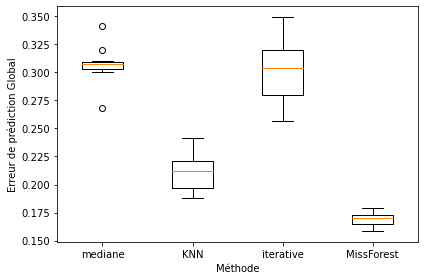

In [86]:
plt.boxplot(distances_global.T, vert=True)
plt.xlabel('Méthode')
plt.ylabel('Erreur de prédiction Global')
locs, labels = plt.xticks()
plt.xticks(locs,labels=methodes)

plt.tight_layout()
plt.savefig('Comparaison_imputation_global.png', dpi=300)

### b) Base de données tara

Evaluation pour la base de données *tara_data*

In [78]:
haptophytes = ['Diatoms',
               'Coccolithophores (Haptophytes)',
               'Dinoflagellates',
               'Prochlorococcus',
               'Synechococcus',
               'chlorophytes',
               'other_Haptophytes']

In [79]:
def evaluation_tara(tara_data_phyto_hplc,methode_imputation):
    tara_data_phyto_hplc_sans_nan=tara_data_phyto_hplc.copy()
    tara_data_phyto_hplc_sans_nan.dropna(inplace=True)
    tableau_pigments=[np.zeros(106) for i in range(0,10)]
    for tab in tableau_pigments:
        compteur=0
        while (compteur/len(tab))<=0.3175:
            tab[np.random.randint(0,106)]=1
            compteur+=1
    tableau_haptophytes=[np.zeros(106) for i in range(0,7)]
    for tab in tableau_haptophytes:
        compteur=0
        while (compteur/len(tab))<=0.3128:
            tab[np.random.randint(0,106)]=1
            compteur+=1
    tableau_repartition=tableau_haptophytes+tableau_pigments
    
    dict={'Diatoms':tableau_repartition[0],
       'Coccolithophores (Haptophytes)':tableau_repartition[1], 'Dinoflagellates':tableau_repartition[2], 'Prochlorococcus':tableau_repartition[3],
       'Synechococcus':tableau_repartition[4], 'chlorophytes':tableau_repartition[5], 'other_Haptophytes':tableau_repartition[6],
       'Chlorophyll a, total':tableau_repartition[7], 'Divinyl chlorophyll a':tableau_repartition[8], 'Chlorophyll b':tableau_repartition[9],
       'Divinyl chlorophyll b':tableau_repartition[10], '19-Hexanoyloxyfucoxanthin':tableau_repartition[11],
       '19-Butanoyloxyfucoxanthin':tableau_repartition[12], 'Fucoxanthin':tableau_repartition[13], 'Peridinin':tableau_repartition[14], 'Alloxanthin':tableau_repartition[15],
       'Zeaxanthin':tableau_repartition[16]}
    
    tara_data_phyto_hplc_avec_nan=tara_data_phyto_hplc_sans_nan.copy()
    index=list(tara_data_phyto_hplc_sans_nan.index)
    for column in tara_data_phyto_hplc_avec_nan.columns:
       for ind in index:
           if dict[column][index.index(ind)]==1:
               tara_data_phyto_hplc_avec_nan.at[ind,column]='NaN'
    
    #Faire l'imputation ici
    #IMPUTATION PAR LA MEDIANE
    if methode_imputation == 'mediane':
        tara_data_phyto_hplc_median_avec_nan = tara_data_phyto_hplc_avec_nan.copy()

        for column in tara_data_phyto_hplc_avec_nan.columns:
             median = tara_data_phyto_hplc[column].median()
             tara_data_phyto_hplc_median_avec_nan[column].fillna(median,inplace=True)
             tara_data_phyto_hplc_imputed = tara_data_phyto_hplc_median_avec_nan.values
    
    #IMPUTATION KNN
    if methode_imputation == 'KNN':
        tara_data_phyto_hplc_KNN_avec_nan = tara_data_phyto_hplc_avec_nan.copy()
        imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights= 'uniform')
        tara_data_phyto_hplc_imputed = imputer.fit_transform(tara_data_phyto_hplc_KNN_avec_nan)
        
    #IMPUTATION ITERATIVE
    if methode_imputation == 'iterative':
        tara_data_phyto_hplc_II_avec_nan = tara_data_phyto_hplc_avec_nan.copy()
        imputer_iteratif = IterativeImputer(random_state=0,max_iter=100)
        tara_data_phyto_hplc_imputed = imputer_iteratif.fit_transform(tara_data_phyto_hplc_II_avec_nan)
        
    #IMPUTATION MISSFOREST
    if methode_imputation == 'MissForest':
        tara_data_phyto_hplc_MF_avec_nan = tara_data_phyto_hplc_avec_nan.copy()
        missforest_imputer = MissForest()
        tara_data_phyto_hplc_imputed = missforest_imputer.fit_transform(tara_data_phyto_hplc_MF_avec_nan)
         
    return np.linalg.norm(tara_data_phyto_hplc_imputed - tara_data_phyto_hplc_sans_nan.values,
                   axis=1), np.linalg.norm(tara_data_phyto_hplc_imputed - tara_data_phyto_hplc_sans_nan.values,
                   axis=1).mean()

In [80]:
# Comparaison des différentes méthodes d'imputation pour tara_data
# On procèdera à 10 initialisations différentes

methodes = ['mediane','KNN','iterative','MissForest']
nb_experiences = 10 
distances = np.zeros([len(methodes),nb_experiences])

for k in range (nb_experiences):
    for i,methode in enumerate(methodes):
        distances[i,k] = evaluation_tara(df_tara_data_normalized,methode)[1]
distances

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


array([[1.4953, 1.4091, 1.6067, 1.5517, 1.6578, 1.7818, 1.593 , 1.7715, 1.7753, 1.4277],
       [1.3468, 1.4034, 1.4832, 1.3888, 1.3786, 1.3342, 1.2235, 1.2963, 1.3354, 1.2116],
       [1.4357, 1.364 , 1.3399, 1.3063, 1.329 , 1.3158, 1.3159, 1.3348, 1.332 , 1.2762],
       [1.2445, 1.2125, 1.2524, 1.0683, 1.1358, 1.0976, 1.3799, 1.084 , 1.2999, 1.1207]])

In [81]:
df_distances = pd.DataFrame(distances.T,columns = methodes)
df_distances.describe()

,mediane,KNN,iterative,MissForest
count,10.00000,10.00000,10.00000,10.00000
mean,1.60700,1.34017,1.33497,1.18957
std,0.13965,0.08194,0.04224,0.10425
min,1.40914,1.21163,1.27620,1.06835
25%,1.50943,1.30580,1.31584,1.10339
50%,1.59982,1.34109,1.33051,1.17414
75%,1.74310,1.38621,1.33865,1.25045
max,1.78177,1.48317,1.43567,1.37992


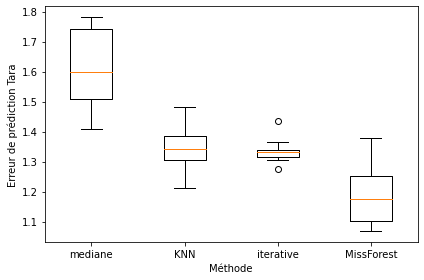

In [85]:
plt.boxplot(distances.T, vert=True)
plt.xlabel('Méthode')
plt.ylabel('Erreur de prédiction Tara')
locs, labels = plt.xticks()
plt.xticks(locs,labels=methodes)

plt.tight_layout()

plt.savefig('Comparaison_imputation_tara.png', dpi=300)

# 5. Classification des données imputées

In [83]:
imputation = 'KNN'
#imputation = 'IterativeImputer'

if imputation == 'KNN':
    df_global_data_imputed = df_global_data_KNNimputed
    df_tara_data_imputed = df_global_tara_KNNimputed
if imputation == 'Iterative Imputer':
    df_global_data_imputed = df_global_data_IIimputed
    df_tara_data_imputed = df_tara_data_IIimputed

NameError: name 'df_global_tara_KNNimputed' is not defined

# 5.1. Simple K-Means

# 5.2. K-Means - CAH - K-Means

### 1er K-Means

Pour simplifier la classification hiérarchique, on va d'abord réaliser une première classification par K-moyennes avec un nombre de clusters élevé. Ces clusters seront ensuite les éléments initiaux de la CAH.

### CAH

In [100]:
L = np.array([1,2,3,4,5,7,8,9,10,7,4,2,1,7,9,6,2])

index_sept = np.where(L==7)
index_sept

(array([ 5,  9, 13], dtype=int64),)